In [1]:
# ============================================
# Logistic Regression — Step 1: Load preprocessing
# ============================================

%run "./02_preprocessing.ipynb"

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\nClass distribution:\n", y_train.value_counts(normalize=True))


Initial shape: (15000, 17)
Exact duplicate rows: 0
Duplicate faculty_id: 0


,faculty_id,academic_rank,tenure_status,years_at_institution,base_salary,teaching_load,research_funding,institution_type,department_size,admin_support,work_life_balance,department_collaboration,promotion_opportunities,publications_last_3_years,student_evaluation_avg,job_market_alternatives,left_institution
0,1,Associate Professor,Tenure-Track,3,70974.758663,6,9960.082453,Community College,Medium,1,3,8,1,7,3.520074,9,0
1,2,Full Professor,Non-Tenure,16,69482.774557,3,108309.536130,Liberal Arts College,Medium,3,3,2,9,4,3.811163,4,0
2,3,Lecturer,Non-Tenure,19,91434.392986,2,10044.468010,Research University,Medium,9,5,9,3,4,3.539667,7,0
3,4,Associate Professor,Non-Tenure,24,65850.710135,6,4159.726828,Research University,Small,5,7,6,1,5,4.351417,9,1
4,5,Associate Professor,Non-Tenure,39,30000.000000,7,10718.111809,Community College,Small,6,6,8,8,5,3.932108,2,0


Train shape: (12000, 15)
Test shape: (3000, 15)

Train target distribution:
left_institution
0    0.726667
1    0.273333
Name: proportion, dtype: float64
Categorical columns: ['academic_rank', 'tenure_status', 'institution_type', 'department_size']
Numeric columns: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding', 'admin_support', 'work_life_balance', 'department_collaboration', 'promotion_opportunities', 'publications_last_3_years', 'student_evaluation_avg', 'job_market_alternatives']
Preprocessor fitted successfully!
Processed shape: (12000, 40)
X_train shape: (12000, 15)
X_test shape: (3000, 15)

Class distribution:
 left_institution
0    0.726667
1    0.273333
Name: proportion, dtype: float64


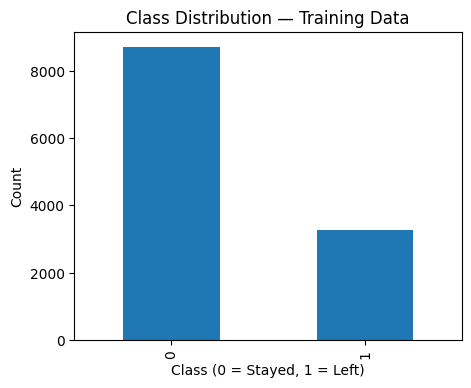

In [2]:
plt.figure(figsize=(5,4))
y_train.value_counts().plot(kind='bar')
plt.title("Class Distribution — Training Data")
plt.xlabel("Class (0 = Stayed, 1 = Left)")
plt.ylabel("Count")
plt.show()


In [3]:
# ============================================
# Logistic Regression — Baseline Model
# ============================================

log_reg = Pipeline([
    ("preprocess", preprocessor),
    ("lr", LogisticRegression(max_iter=500))
])

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("Baseline Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Baseline AUC:", roc_auc_score(y_test, y_prob_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Baseline Logistic Regression Accuracy: 0.7623333333333333
Baseline AUC: 0.7417895502349519

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85      2180
           1       0.64      0.30      0.41       820

    accuracy                           0.76      3000
   macro avg       0.71      0.62      0.63      3000
weighted avg       0.74      0.76      0.73      3000



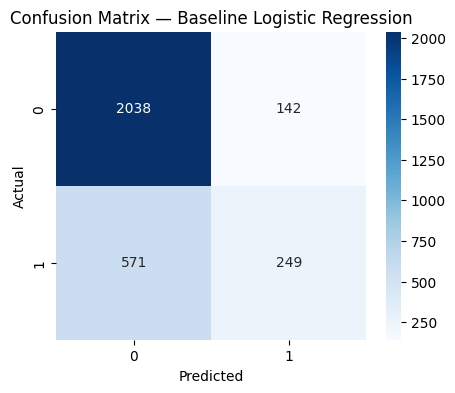

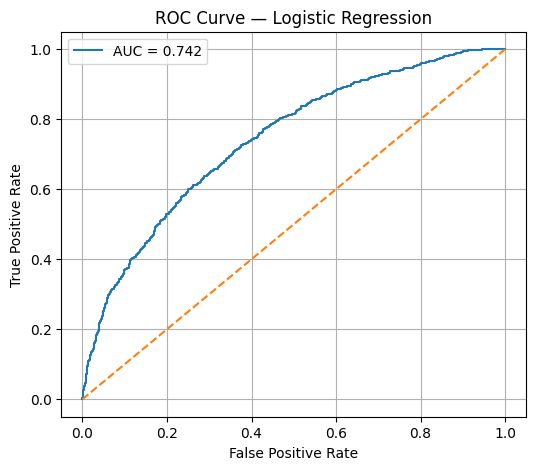

In [4]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Baseline Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_lr):.3f}")
plt.plot([0,1],[0,1],"--")
plt.title("ROC Curve — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# ============================================
# Logistic Regression — With Class Weight
# ============================================

log_reg_weighted = Pipeline([
    ("preprocess", preprocessor),
    ("lr", LogisticRegression(
        class_weight='balanced',
        max_iter=500
    ))
])

log_reg_weighted.fit(X_train, y_train)

y_pred_lr_w = log_reg_weighted.predict(X_test)
y_prob_lr_w = log_reg_weighted.predict_proba(X_test)[:, 1]

print("Weighted Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr_w))
print("Weighted AUC:", roc_auc_score(y_test, y_prob_lr_w))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr_w))


Weighted Logistic Regression Accuracy: 0.6646666666666666
Weighted AUC: 0.7417996196017005

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.65      0.74      2180
           1       0.43      0.70      0.53       820

    accuracy                           0.66      3000
   macro avg       0.64      0.67      0.64      3000
weighted avg       0.74      0.66      0.68      3000



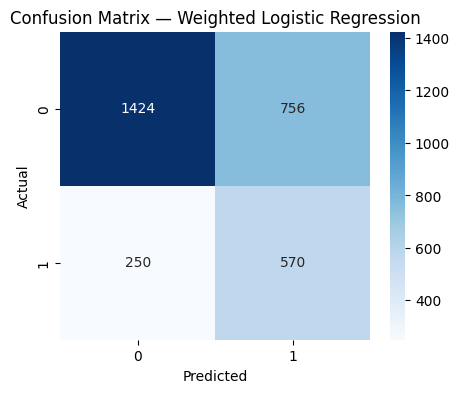

In [6]:
cm = confusion_matrix(y_test, y_pred_lr_w)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Weighted Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [7]:
# ============================================
# Logistic Regression — Regularization Tuning
# ============================================

from sklearn.model_selection import GridSearchCV

param_grid = {
    "lr__C": [0.01, 0.1, 1, 10, 50],
    "lr__penalty": ["l2"]
}

log_reg_tuned = Pipeline([
    ("preprocess", preprocessor),
    ("lr", LogisticRegression(
        class_weight='balanced',
        solver="lbfgs",
        max_iter=500
    ))
])

grid_lr = GridSearchCV(
    estimator=log_reg_tuned,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("Best Params:", grid_lr.best_params_)
print("Best Cross-Validated AUC:", grid_lr.best_score_)


Best Params: {'lr__C': 0.01, 'lr__penalty': 'l2'}
Best Cross-Validated AUC: 0.7292111034304969


Final Logistic Regression Accuracy: 0.6646666666666666
Final AUC: 0.7418712239874693

Final Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.65      0.74      2180
           1       0.43      0.70      0.53       820

    accuracy                           0.66      3000
   macro avg       0.64      0.67      0.64      3000
weighted avg       0.74      0.66      0.68      3000



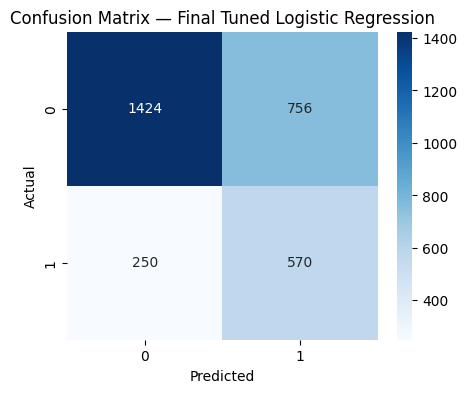

In [8]:
best_lr = grid_lr.best_estimator_

y_pred_best = best_lr.predict(X_test)
y_prob_best = best_lr.predict_proba(X_test)[:, 1]

print("Final Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_best))
print("Final AUC:", roc_auc_score(y_test, y_prob_best))
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Final Tuned Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


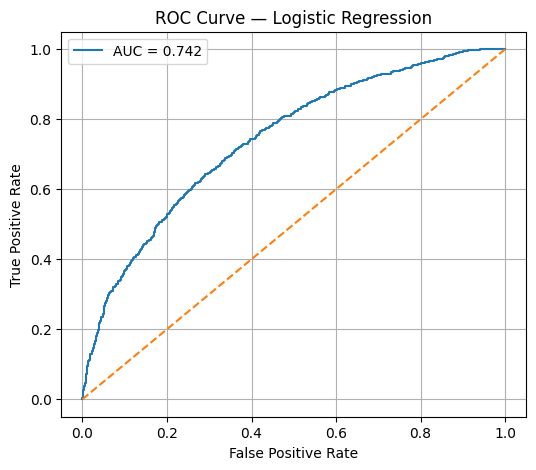

In [9]:
# ============================================
# ROC Curve — Final Logistic Regression
# ============================================

fpr, tpr, _ = roc_curve(y_test, y_prob_best)
auc_lr = roc_auc_score(y_test, y_prob_best)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_lr:.3f}')
plt.plot([0,1], [0,1], '--')
plt.title("ROC Curve — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


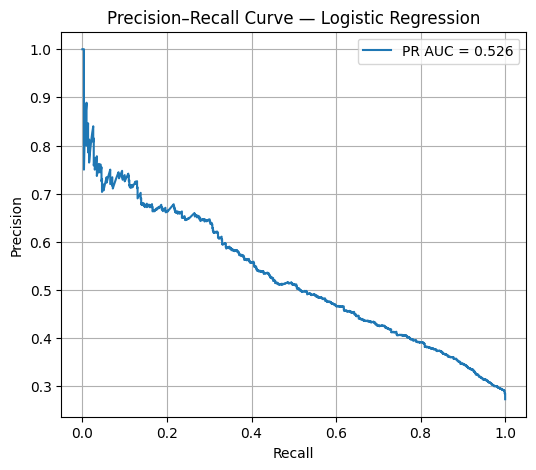

In [10]:
# ============================================
# Precision-Recall Curve — Logistic Regression
# ============================================

from sklearn.metrics import precision_recall_curve, auc

prec, rec, _ = precision_recall_curve(y_test, y_prob_best)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'PR AUC = {pr_auc:.3f}')
plt.title("Precision–Recall Curve — Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()


In [12]:
# ============================================
# SAVE FINAL LOGISTIC REGRESSION MODEL
# ============================================

import joblib

final_log_reg_model = log_reg_weighted   # your final model variable
joblib.dump(final_log_reg_model, "../models/log_reg.pkl")

print("Saved Logistic Regression model as log_reg.pkl")


Saved Logistic Regression model as log_reg.pkl
